In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import requests
from bs4 import BeautifulSoup
import os


In [15]:
# Step 1: Create the "data" directory if it doesn't exist
if not os.path.exists('data'):
    os.makedirs('data')

# Step 2: Define a function to scrape reviews from a single page
def scrape_reviews(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    reviews = []
    
    # Find all review articles
    review_articles = soup.find_all('article', itemprop='review')
    
    for article in review_articles:
        # Extract the review date
        date_published = article.find('meta', itemprop='datePublished')['content']
        
        # Extract the title of the review
        review_title = article.find('h2', class_='text_header').text.strip()
        
        # Extract the author name and country
        author = article.find('span', itemprop='name').text.strip()
        country = article.find('h3', class_='text_sub_header').text.split('(')[-1].split(')')[0].strip()
        
        # Extract the review body
        review_body_div = article.find('div', itemprop='reviewBody')
        review_body = review_body_div.get_text(separator=' ', strip=True) if review_body_div else ''
        
        # Remove specific verification text from review body
        review_body = review_body.replace('✅ Trip Verified |', '').replace('Not Verified |', '').strip()
        
        # Extract the verification status separately
        verification_status_div = article.find('strong') and article.find('strong').find('em')
        verification_status = verification_status_div.get_text(strip=True) if verification_status_div else 'Not Verified'
        
        # Extract the star rating based on filled stars
        rating_stars_div = article.find('td', class_='review-rating-stars')
        filled_stars = len(rating_stars_div.find_all('span', class_='star fill')) if rating_stars_div else 0
        
        # Extract additional ratings for specific categories
        ratings = {}
        for row in article.find_all('tr'):
            category = row.find('td', class_='review-rating-header').text.strip()
            value = len(row.find_all('span', class_='star fill')) if row.find('td', class_='review-rating-stars') else row.find('td', class_='review-value').text.strip()
            ratings[category] = value
        
        # Check if the review is recommended
        recommended = article.find('td', class_='review-value rating-yes')
        recommended = 'Yes' if recommended else 'No'
        
        # Append the review data to the list
        reviews.append({
            'Date': date_published,
            'Rating': filled_stars,
            'Title': review_title,
            'Author': author,
            'Country': country,
            'Review': review_body,
            'Recommended': recommended,
            'Verification Status': verification_status,
            **ratings
        })
    
    return reviews

# Step 3: Define a function to scrape reviews from multiple pages
def scrape_all_pages(base_url, start_page, end_page):
    all_reviews = []
    
    for page in range(start_page, end_page + 1):
        url = f"{base_url}page/{page}/"
        print(f"Scraping page {page}...")
        reviews = scrape_reviews(url)
        
        if reviews:
            all_reviews.extend(reviews)
        else:
            print(f"No more reviews found on page {page}. Stopping.")
            break
    
    return all_reviews

# Define the base URL and page range
base_url = 'https://www.airlinequality.com/airline-reviews/british-airways/'
start_page = 1
end_page = 5  # Adjust based on the total number of pages

# Step 4: Scrape all pages
all_reviews = scrape_all_pages(base_url, start_page, end_page)

# Step 5: Save the scraped data to a CSV file
df = pd.DataFrame(all_reviews)
df.to_csv('data/airline_reviews.csv', index=False)

# Print a preview of the scraped data
print("Done")
print(df.head())


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Done
         Date  Rating                                 Title       Author  \
0  2024-08-15       1     "no acknowledgment or resolution"      C Hayne   
1  2024-08-12       5                 "Outstanding service"     C Porter   
2  2024-08-12       3              "the crew were fabulous"      G Jones   
3  2024-08-11       3  “customer service has been horrible”  Edward King   
4  2024-08-09       1           "Not as much as an apology"       N Kwok   

          Country                                             Review  \
0  United Kingdom  Before my flight, I was forced by the ground s...   
1  United Kingdom  British Airways at its best. Outstanding servi...   
2         Lebanon  An excellent flight! Despite this being a 4.5 ...   
3   United States  I recently traveled with British Airways and h...   
4  United Kingdom  My family and I were booked to leave London fo...   

  Recommen

df.count()

In [7]:
df.count()

Date                      3260
Rating                    3260
Title                     3260
Author                    3260
Country                   3260
Review                    3260
Recommended               3260
Verification Status       3260
Type Of Traveller         3070
Seat Type                 3257
Route                     3066
Date Flown                3063
Seat Comfort              3138
Cabin Staff Service       3124
Ground Service            2992
Wifi & Connectivity        661
Value For Money           3260
Aircraft                  2003
Food & Beverages          2843
Inflight Entertainment    2054
dtype: int64

In [16]:
df.head()

,Date,Rating,Title,Author,Country,Review,Recommended,Verification Status,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Wifi & Connectivity,Value For Money,Aircraft,Food & Beverages,Inflight Entertainment
0,2024-08-15,1,"""no acknowledgment or resolution""",C Hayne,United Kingdom,"Before my flight, I was forced by the ground s...",no,Not Verified,Solo Leisure,Economy Class,London to Basel,June 2024,1.0,1.0,1.0,1.0,1,NaN,NaN,NaN
1,2024-08-12,5,"""Outstanding service""",C Porter,United Kingdom,British Airways at its best. Outstanding servi...,yes,Trip Verified,Solo Leisure,Business Class,Vancouver to London,July 2024,5.0,5.0,4.0,NaN,4,A350,5.0,5.0
2,2024-08-12,3,"""the crew were fabulous""",G Jones,Lebanon,An excellent flight! Despite this being a 4.5 ...,yes,Trip Verified,Solo Leisure,Economy Class,London to Amman,August 2024,3.0,5.0,4.0,NaN,4,A320,4.0,NaN
3,2024-08-11,3,“customer service has been horrible”,Edward King,United States,I recently traveled with British Airways and h...,no,Trip Verified,Family Leisure,Economy Class,Barcelona to Dallas via Heathrow,August 2024,3.0,4.0,2.0,NaN,3,A380,4.0,4.0
4,2024-08-09,1,"""Not as much as an apology""",N Kwok,United Kingdom,My family and I were booked to leave London fo...,no,Trip Verified,Family Leisure,Economy Class,London to Hong Kong,August 2024,1.0,NaN,1.0,NaN,1,NaN,NaN,NaN


In [9]:
df.columns.values

array(['Date', 'Rating', 'Title', 'Author', 'Country', 'Review',
       'Recommended', 'Verification Status', 'Type Of Traveller',
       'Seat Type', 'Route', 'Date Flown', 'Seat Comfort',
       'Cabin Staff Service', 'Ground Service', 'Wifi & Connectivity',
       'Value For Money', 'Aircraft', 'Food & Beverages',
       'Inflight Entertainment'], dtype=object)

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Rating', data=df, palette='viridis')


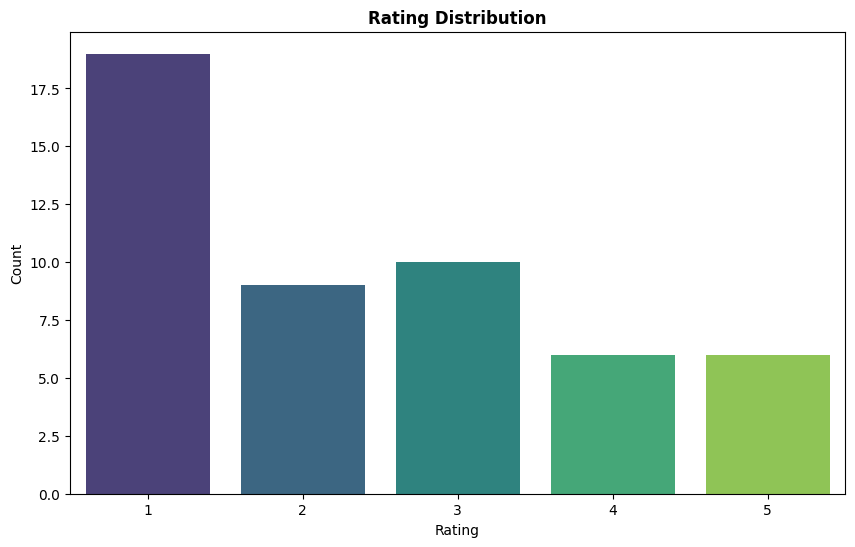

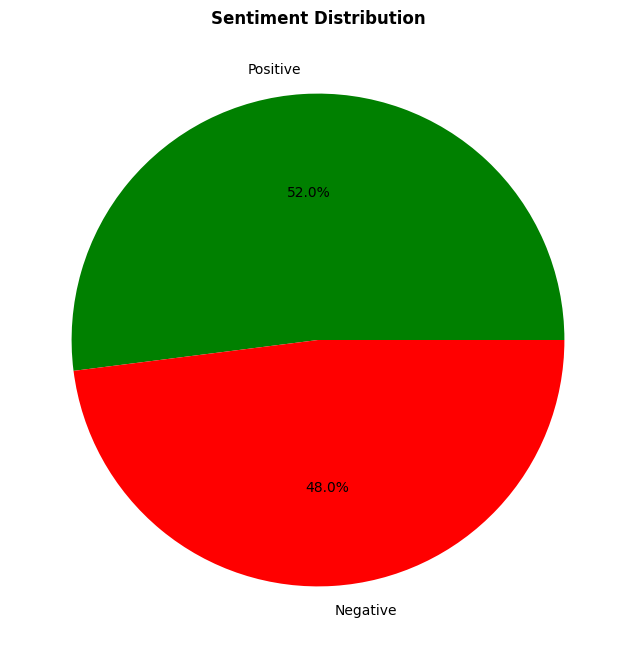

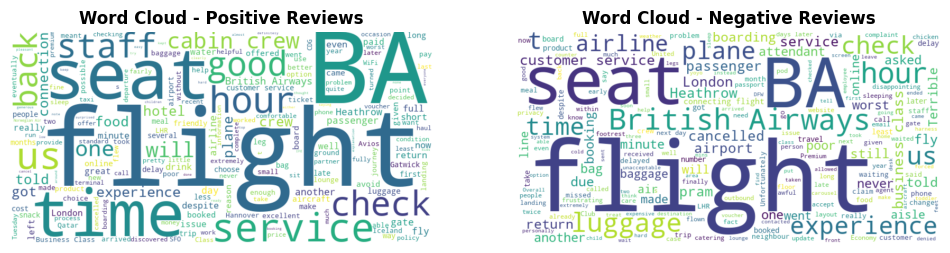

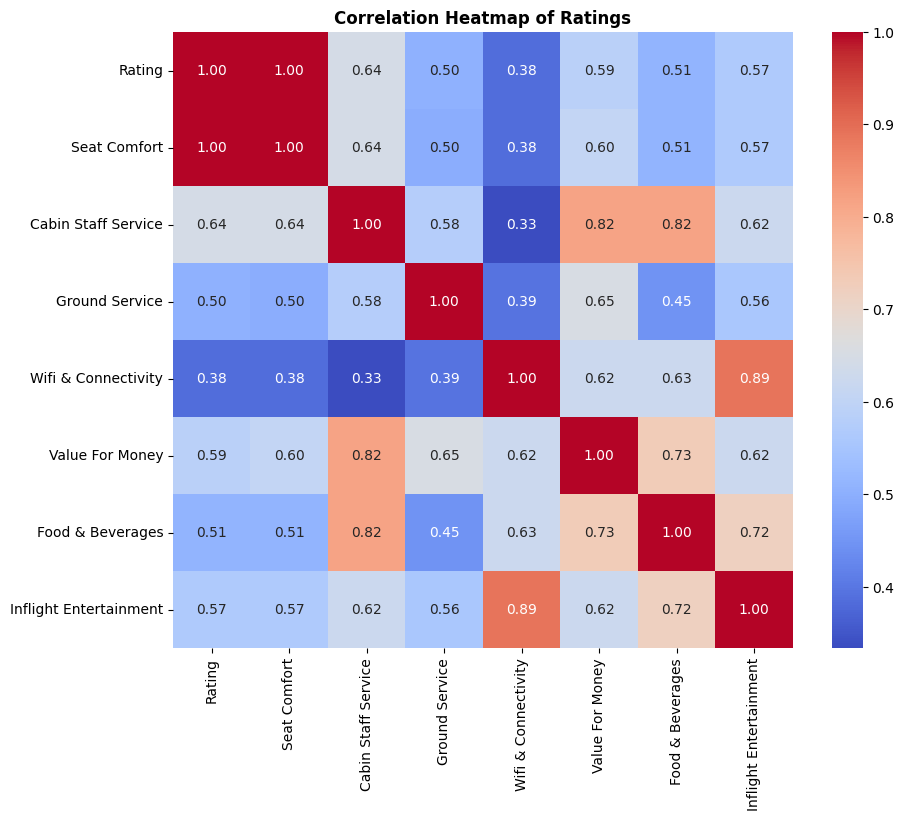

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=route_ratings.values, y=route_ratings.index, palette='Spectral')


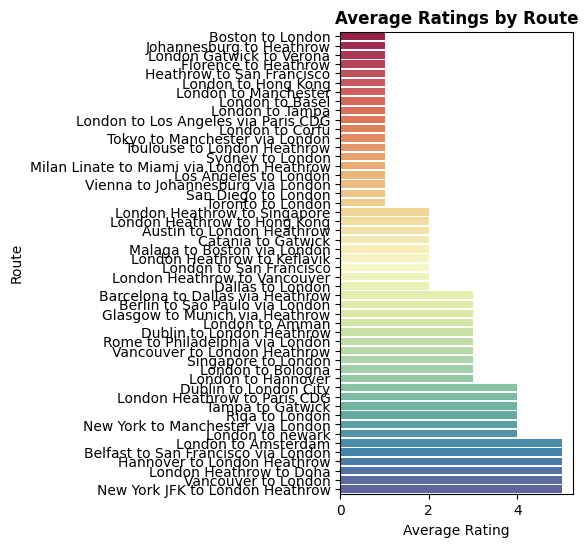

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='Type Of Traveller', x='Rating', palette='muted')


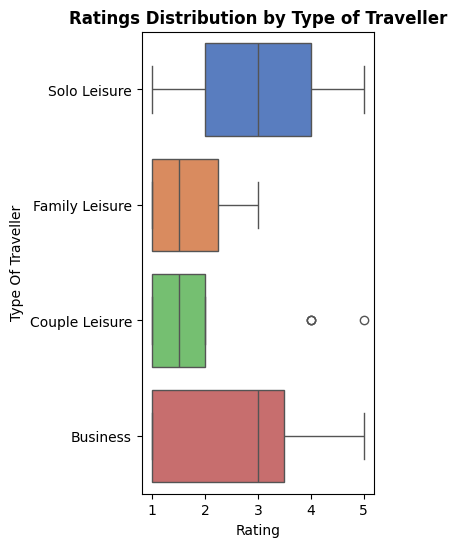

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, y='Food & Beverages', x='Rating', palette='Set2')


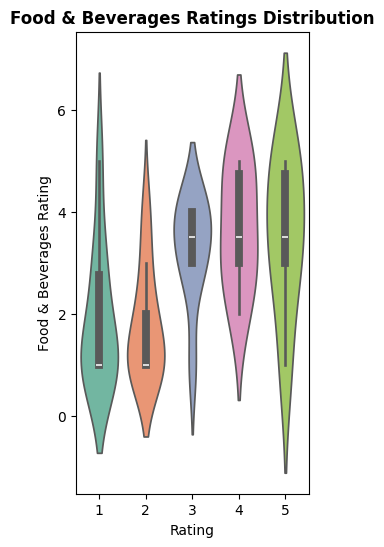

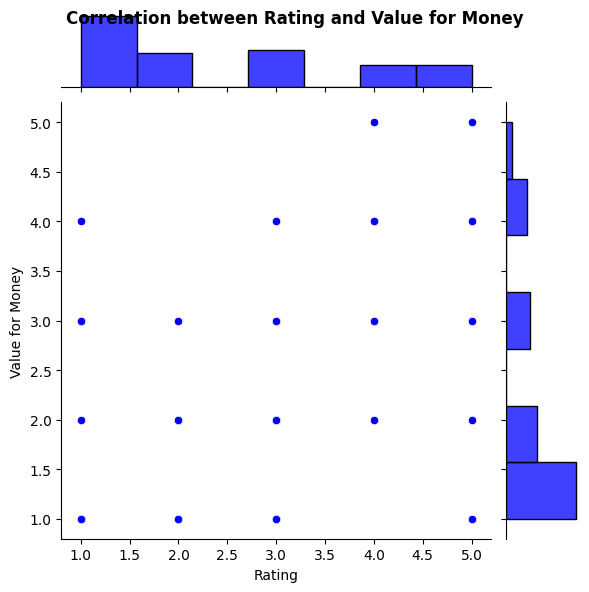

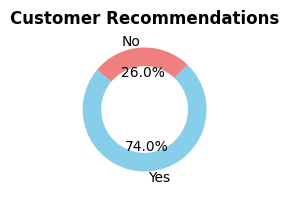

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=aircraft_ratings.values, y=aircraft_ratings.index, palette='coolwarm')


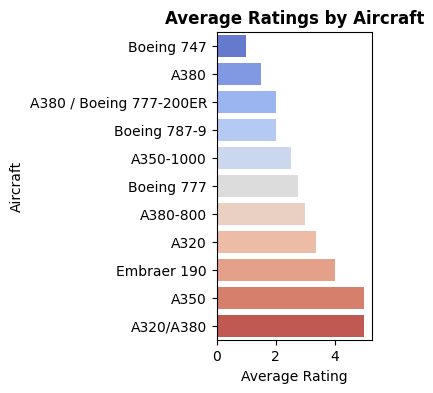

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seat_type_ratings.values, y=seat_type_ratings.index, palette='coolwarm')


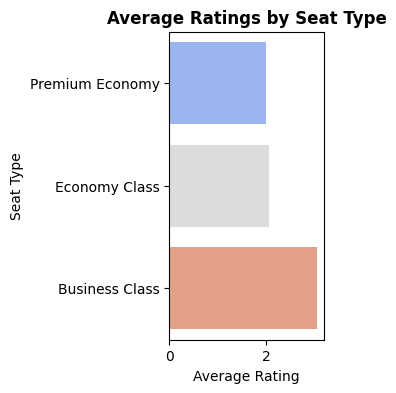

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='Ground Service', x='Rating', palette='Set3')


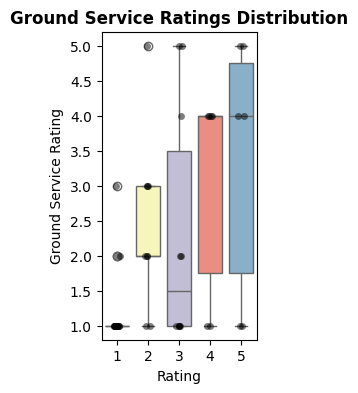

C:\Users\JAYESH R KESARI\AppData\Local\Temp\ipykernel_7708\1873815115.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, y='Wifi & Connectivity', x='Rating', palette='Set3')


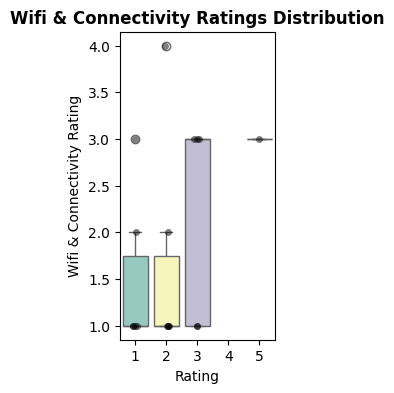

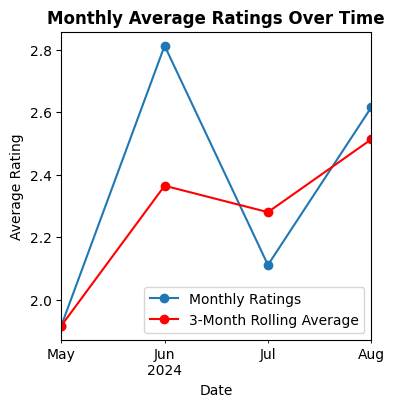

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.dates as mdates

# Load the data
df = pd.read_csv('data/airline_reviews.csv')

# Clean and preprocess data
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Seat Comfort'] = pd.to_numeric(df['Seat Comfort'], errors='coerce')
df['Cabin Staff Service'] = pd.to_numeric(df['Cabin Staff Service'], errors='coerce')
df['Ground Service'] = pd.to_numeric(df['Ground Service'], errors='coerce')
df['Wifi & Connectivity'] = pd.to_numeric(df['Wifi & Connectivity'], errors='coerce')
df['Value For Money'] = pd.to_numeric(df['Value For Money'], errors='coerce')
df['Food & Beverages'] = pd.to_numeric(df['Food & Beverages'], errors='coerce')
df['Inflight Entertainment'] = pd.to_numeric(df['Inflight Entertainment'], errors='coerce')

# 1. Overall Customer Satisfaction

# Bar plot for Rating Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='viridis')
plt.title('Rating Distribution', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.gcf().set_facecolor('none')
plt.show()


# 2. Sentiment Analysis
def sentiment_analysis(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Review'].apply(lambda x: sentiment_analysis(str(x)))

# Pie chart for Sentiment Distribution
sentiment_counts = df['Sentiment'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=['green', 'red', 'gray'])
plt.title('Sentiment Distribution', fontweight='bold')
plt.gcf().set_facecolor('none')
plt.show()

# Word Clouds for Positive and Negative Reviews
positive_reviews = df[df['Sentiment'] == 'Positive']['Review']
negative_reviews = df[df['Sentiment'] == 'Negative']['Review']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_reviews))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Reviews', fontweight='bold')
plt.axis('off')
plt.gcf().set_facecolor('none')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(' '.join(negative_reviews))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews', fontweight='bold')
plt.axis('off')
plt.gcf().set_facecolor('none')

plt.show()

# 3. Service-Specific Insights
# Heatmap for Service Correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df[['Rating', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service', 'Wifi & Connectivity', 'Value For Money', 'Food & Beverages', 'Inflight Entertainment']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Ratings', fontweight='bold')
plt.gcf().set_facecolor('none')
plt.show()

# 4. Route and Travel Type Analysis

# Route Ratings with color-coding
route_ratings = df.groupby('Route')['Rating'].mean().sort_values()

plt.figure(figsize=(3, 6))
sns.barplot(x=route_ratings.values, y=route_ratings.index, palette='Spectral')
plt.title('Average Ratings by Route', fontweight='bold')
plt.xlabel('Average Rating')
plt.gcf().set_facecolor('none')
plt.show()

# Box plot for Traveler Type Ratings
traveler_type_ratings = df.groupby('Type Of Traveller')['Rating'].mean().sort_values()

plt.figure(figsize=(3, 6))
sns.boxplot(data=df, y='Type Of Traveller', x='Rating', palette='muted')
plt.title('Ratings Distribution by Type of Traveller', fontweight='bold')
plt.xlabel('Rating')
plt.gcf().set_facecolor('none')
plt.show()

# 5. Food & Beverages Quality

# Violin plot for Food & Beverages Ratings
plt.figure(figsize=(3, 6))
sns.violinplot(data=df, y='Food & Beverages', x='Rating', palette='Set2')
plt.title('Food & Beverages Ratings Distribution', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Food & Beverages Rating')
plt.gcf().set_facecolor('none')
plt.show()

# 6. Value for Money

# Joint plot for Value for Money
sns.jointplot(data=df, x='Rating', y='Value For Money', kind='scatter', color='blue')
plt.suptitle('Correlation between Rating and Value for Money', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Value for Money')
plt.gcf().set_facecolor('none')
plt.show()

# 7. Customer Recommendations

# Donut chart for Recommendations
recommendation_percentage = df['Recommended'].value_counts(normalize=True) * 100

plt.figure(figsize=(2, 4))
plt.pie(recommendation_percentage, labels=['Yes', 'No'], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'lightcoral'], wedgeprops=dict(width=0.3))
plt.title('Customer Recommendations', fontweight='bold')
plt.gcf().set_facecolor('none')
plt.show()

# 8. Aircraft and Seat Type Preferences

# Bar plot for Aircraft Ratings
aircraft_ratings = df.groupby('Aircraft')['Rating'].mean().sort_values()

plt.figure(figsize=(2, 4))
sns.barplot(x=aircraft_ratings.values, y=aircraft_ratings.index, palette='coolwarm')
plt.title('Average Ratings by Aircraft', fontweight='bold')
plt.xlabel('Average Rating')
plt.gcf().set_facecolor('none')
plt.show()

# Bar plot for Seat Type Ratings
seat_type_ratings = df.groupby('Seat Type')['Rating'].mean().sort_values()

plt.figure(figsize=(2, 4))
sns.barplot(x=seat_type_ratings.values, y=seat_type_ratings.index, palette='coolwarm')
plt.title('Average Ratings by Seat Type', fontweight='bold')
plt.xlabel('Average Rating')
plt.gcf().set_facecolor('none')
plt.show()

# 9. Ground Service and Connectivity

# Strip plot for Ground Service Ratings
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y='Ground Service', x='Rating', palette='Set3')
sns.stripplot(data=df, y='Ground Service', x='Rating', color='black', alpha=0.5)
plt.title('Ground Service Ratings Distribution', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Ground Service Rating')
plt.gcf().set_facecolor('none')
plt.show()

# Strip plot for Wifi & Connectivity Ratings
plt.figure(figsize=(2, 4))
sns.boxplot(data=df, y='Wifi & Connectivity', x='Rating', palette='Set3')
sns.stripplot(data=df, y='Wifi & Connectivity', x='Rating', color='black', alpha=0.5)
plt.title('Wifi & Connectivity Ratings Distribution', fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Wifi & Connectivity Rating')
plt.gcf().set_facecolor('none')
plt.show()

# 10. Time-Based Trends

# Rolling Average for Monthly Ratings
df['YearMonth'] = df['Date'].dt.to_period('M')
monthly_ratings = df.groupby('YearMonth')['Rating'].mean()
monthly_ratings_rolling = monthly_ratings.rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(4, 4))
monthly_ratings.plot(marker='o', linestyle='-', label='Monthly Ratings')
monthly_ratings_rolling.plot(marker='o', linestyle='-', label='3-Month Rolling Average', color='red')
plt.title('Monthly Average Ratings Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend()
plt.gcf().set_facecolor('none')
plt.show()


In [19]:
# 1. Calculate Overall Average Rating
overall_avg_rating = df['Rating'].mean()

# 2. Calculate Averages for Specific Aspects
avg_seat_comfort = df['Seat Comfort'].mean()
avg_cabin_staff_service = df['Cabin Staff Service'].mean()
avg_food_beverages = df['Food & Beverages'].mean()
avg_ground_service = df['Ground Service'].mean()
avg_wifi_connectivity = df['Wifi & Connectivity'].mean()
avg_value_for_money = df['Value For Money'].mean()
avg_inflight_entertainment = df['Inflight Entertainment'].mean()

# 3. Sentiment Analysis Summary
sentiment_counts = df['Sentiment'].value_counts(normalize=True) * 100

# 4. Recommendation Percentage
recommendation_percentage = df['Recommended'].value_counts(normalize=True) * 100

# 5. Display Results
print(f"Overall Average Rating: {overall_avg_rating:.2f}")
print(f"Average Seat Comfort Rating: {avg_seat_comfort:.2f}")
print(f"Average Cabin Staff Service Rating: {avg_cabin_staff_service:.2f}")
print(f"Average Food & Beverages Rating: {avg_food_beverages:.2f}")
print(f"Average Ground Service Rating: {avg_ground_service:.2f}")
print(f"Average Wifi & Connectivity Rating: {avg_wifi_connectivity:.2f}")
print(f"Average Value For Money Rating: {avg_value_for_money:.2f}")
print(f"Average Inflight Entertainment Rating: {avg_inflight_entertainment:.2f}")

print("\nSentiment Distribution:")
print(sentiment_counts)

print("\nRecommendation Percentage:")
print(recommendation_percentage)


Overall Average Rating: 2.42
Average Seat Comfort Rating: 2.48
Average Cabin Staff Service Rating: 2.87
Average Food & Beverages Rating: 2.67
Average Ground Service Rating: 2.14
Average Wifi & Connectivity Rating: 1.83
Average Value For Money Rating: 2.10
Average Inflight Entertainment Rating: 2.73

Sentiment Distribution:
Sentiment
Positive    52.0
Negative    48.0
Name: proportion, dtype: float64

Recommendation Percentage:
Recommended
no     74.0
yes    26.0
Name: proportion, dtype: float64
